# Quantization scheme

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

mean/mu = -0.9978168054391765 | std/sigma = 0.4987453019202385 


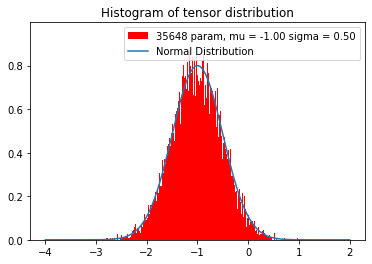

In [32]:
# Parameters for normal distribution
mu = -1
sigma = 0.5
param = 35648
x_float = np.random.normal(mu, sigma, param)


mu = np.mean(x_float)
sigma = np.std(x_float)

print("mean/mu = {} | std/sigma = {} ".format(mu, sigma))

plt.title(label="Histogram of tensor distribution")
plt.hist(x_float, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])

# affichage de la courbe de la distribution normale pour comparaison
x = np.linspace(-3+mu,3+mu,1000)
y = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

plt.plot(x, y, label="Normal Distribution")

plt.legend()
plt.show()


Sym Quantize from float32 to intX

127 3.081190632216224
M 8, a_max 127, s 0.02426134356075767


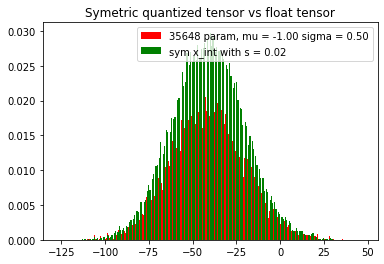

In [33]:
M = 8
a_max  = (pow(2,M-1)) - 1

print(a_max, np.max(np.abs(x_float)))

f_max  = np.max(np.abs(x_float))

s_sym = (f_max)/(a_max)

print("M {}, a_max {}, s {}".format(M, a_max, s_sym))

x_int = np.clip(np.round(x_float/s_sym), -a_max, a_max)


plt.title(label="Symetric quantized tensor vs float tensor")
plt.hist(x_float/s_sym, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])
plt.hist(x_int, bins=pow(2,M),  density=True, label=(f"sym x_int with s = {s_sym:.2f}"), color= ['green'])

plt.legend()
plt.show()

Asym Quantize from float32 to intX

-3.081190632216224 1.1364050421200034
M 8, f_min -3.08, f_max 1.14, a_min -128, a_max 127, s 0.01653959087974991, z 58


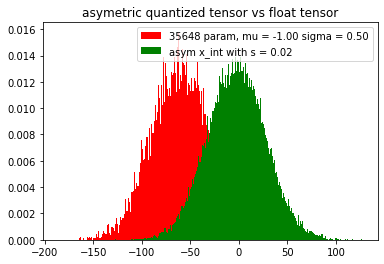

In [34]:
M = M
a_min_asym  = - pow(2,M-1)
a_max_asym  = pow(2,M-1) - 1

f_max_asym  = np.max(x_float)
f_min_asym = np.min(x_float)

print(f_min_asym, f_max_asym)

s_asym = (f_max_asym - f_min_asym)/(a_max_asym - a_min_asym)

z_int = - round(f_min_asym/s_asym) + a_min_asym

print("M {}, f_min {:.03}, f_max {:.03}, a_min {}, a_max {}, s {}, z {}".format(M, f_min_asym, f_max_asym, a_min_asym, a_max_asym, s_asym, z_int))

x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min_asym, a_max_asym)


plt.title(label="asymetric quantized tensor vs float tensor")
plt.hist(x_float/s_asym, bins=1000, density=True, label=(f"{param} param, mu = {mu:.2f} sigma = {sigma:.2f}"), color = ['red'])
plt.hist(x_int_asym, bins=pow(2,M),  density=True, label=(f"asym x_int with s = {s_asym:.2f}"), color= ['green'])

plt.legend()
plt.show()

dequantize from intX to float32 for sym and asym

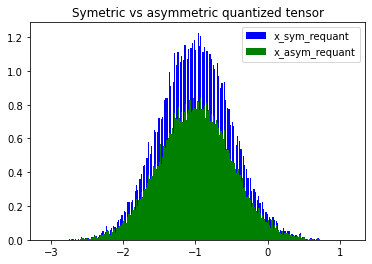

In [35]:
x_sym_requant = s_sym*(x_int)
x_asym_requant = s_asym*(x_int_asym-z_int)

plt.title(label="Symetric vs asymmetric quantized tensor")
plt.hist(x_sym_requant, bins=pow(2,M),  density=True, label="x_sym_requant", color= ['blue'])
plt.hist(x_asym_requant, bins=pow(2,M),  density=True, label="x_asym_requant", color= ['green'])


plt.legend()
plt.show()

Show error for each scheme

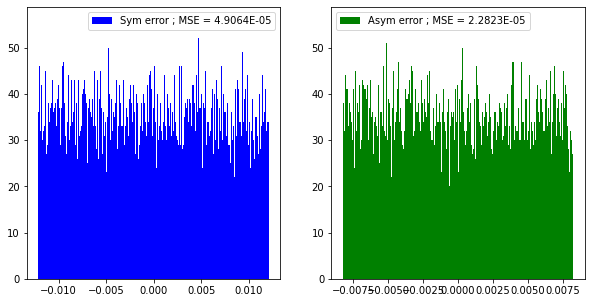

In [36]:
MSE_sym = ((x_sym_requant - x_float)**2).mean()
MSE_asym = ((x_asym_requant - x_float)**2).mean()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(x_sym_requant - x_float, label=f"Sym error ; MSE = {MSE_sym:.4E}", bins=1000, color= ['blue'])
axs[0].legend()
axs[1].hist(x_asym_requant - x_float, label=f"Asym error ; MSE = {MSE_asym:.4E}", bins=1000, color= ['green'])
axs[1].legend()
plt.show()

Show error for each scheme on the same histogram

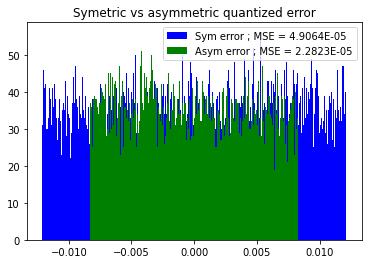

In [37]:

plt.title(label="Symetric vs asymmetric quantized error")
plt.hist(x_sym_requant - x_float, bins=1000, label=f"Sym error ; MSE = {MSE_sym:.4E}", color= ['blue'])

plt.hist(x_asym_requant - x_float, bins=1000, label=f"Asym error ; MSE = {MSE_asym:.4E}", color= ['green'])

plt.legend()
plt.show()

# Compare symmetric and asymmetric

Fake symmetric quantization function

In [38]:
def fake_sym_quant(x_float, M=8):
    a_max  = (pow(2,M-1)) - 1

    f_max  = np.max(np.abs(x_float))

    s_sym = (f_max)/(a_max)

    x_int = np.clip(np.round(x_float/s_sym), -a_max, a_max)

    x_sym_requant = s_sym*(x_int)

    return x_sym_requant

Fake asymmetric quantization function

In [39]:
def fake_asym_quant(x_float, M=8):
    a_min_asym  = - pow(2,M-1)
    a_max_asym  = pow(2,M-1) - 1

    f_max_asym  = np.max(x_float)
    f_min_asym = np.min(x_float)

    s_asym = (f_max_asym - f_min_asym)/(a_max_asym - a_min_asym)

    z_int = - round(f_min_asym/s_asym) + a_min_asym

    x_int_asym = np.clip(np.round(x_float/s_asym)+z_int, a_min_asym, a_max_asym)

    x_asym_requant = s_asym*(x_int_asym-z_int)

    return x_asym_requant

Compare for mu range (-mu_r,mu_r)

for mu = -10 ; MSE : sym > 7.33E-04 asym > 2.02E-05 ; sym - asym = 7.13E-04
for mu = -9 ; MSE : sym > 6.10E-04 asym > 2.13E-05 ; sym - asym = 5.89E-04
for mu = -8 ; MSE : sym > 5.44E-04 asym > 2.20E-05 ; sym - asym = 5.22E-04
for mu = -7 ; MSE : sym > 4.19E-04 asym > 2.18E-05 ; sym - asym = 3.97E-04
for mu = -6 ; MSE : sym > 3.35E-04 asym > 2.21E-05 ; sym - asym = 3.13E-04
for mu = -5 ; MSE : sym > 2.56E-04 asym > 2.14E-05 ; sym - asym = 2.34E-04
for mu = -4 ; MSE : sym > 1.97E-04 asym > 2.14E-05 ; sym - asym = 1.75E-04
for mu = -3 ; MSE : sym > 1.42E-04 asym > 2.30E-05 ; sym - asym = 1.19E-04
for mu = -2 ; MSE : sym > 8.26E-05 asym > 2.07E-05 ; sym - asym = 6.19E-05
for mu = -1 ; MSE : sym > 5.08E-05 asym > 2.29E-05 ; sym - asym = 2.79E-05
for mu = 0 ; MSE : sym > 3.00E-05 asym > 2.46E-05 ; sym - asym = 5.41E-06
for mu = 1 ; MSE : sym > 4.63E-05 asym > 2.10E-05 ; sym - asym = 2.53E-05
for mu = 2 ; MSE : sym > 7.69E-05 asym > 2.05E-05 ; sym - asym = 5.64E-05
for mu = 3 ; MSE : sym > 1.

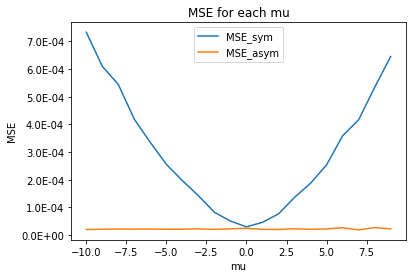

In [40]:
# Normal distribution parameters
M = 8
sigma = 0.5
param = 35648
mu_r = 10

mu_range = np.array(range(-mu_r,mu_r))
MSE_sym = []
MSE_asym = []

for mu in mu_range :
    x_float = np.random.normal(mu, sigma, param)
    x_sym_requant = fake_sym_quant(x_float, M)
    MSE_sym.append(((x_sym_requant - x_float)**2).mean())
    x_asym_requant = fake_asym_quant(x_float, M)
    MSE_asym.append(((x_asym_requant - x_float)**2).mean())

for i, mu in enumerate(mu_range) :
    print(f"for mu = {mu} ; MSE : sym > {MSE_sym[i]:.2E} asym > {MSE_asym[i]:.2E} ; sym - asym = {(MSE_sym[i]-MSE_asym[i]):.2E}")
plt.title("MSE for each mu")
plt.plot(mu_range, MSE_sym, label = "MSE_sym")
plt.plot(mu_range, MSE_asym, label = "MSE_asym")
plt.xlabel("mu")
plt.ylabel("MSE")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1E}')) # 2 decimal places
plt.legend()
plt.show()